### Phys 629, Fall 2023, University of Mississippi


# Lecture 12, Chapter 4: Classical Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Confidence Estimating: Bootstrapping & Jackknifing <a class="anchor" id="three"></a>

Most ways of computing confidence limits and ucnertainties on measured model parameters assume that the distribution is Gaussian and our samples are large. But even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using ***resampling*** strategies.

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.

### Bootstrap Method

In bootstrapping, we map the uncertainty of model parameters by re-sampling from our data (with replacement) $B$ times. This is relatively new (Efron, 1979) and was named in inspiration of "*pulling oneself up by one's bootstraps*".

When sampling from observed data of length $N$ with replacement, there are $N!$ distinct combinations of new observed datasets, and there is only a $N!/N^N$ probability of getting back the original dataset (even for $N=10$ this is only $0.00036$). 

With $B$ new bootstrap datasets, we compute our statistics on each to obtain $B$ measures of our parameters. So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once (and this is ok).

**EXAMPLE**
- We have an original dataset of $1000$ points drawn from a Gaussian distribution. 
- We can only measure the standard deviation of the distribution once with this dataset. 
- Our previous strategies showed that we can use a *Fisher estimate* or an *analytic estimate* of the sample standard deviation uncertainty. 
- Instead, we use the bootstrap method to resample the data $10,000$ times, and compute the standard deviation and $\sigma_G$ on each new dataset. 
- This will map out the uncertainty distribution of those statistics, allowing us to quote confidence limits in our actual measured value. 

<font color='red'>Read through the next cell carefully to understand what's happening when you execute it.</font> 

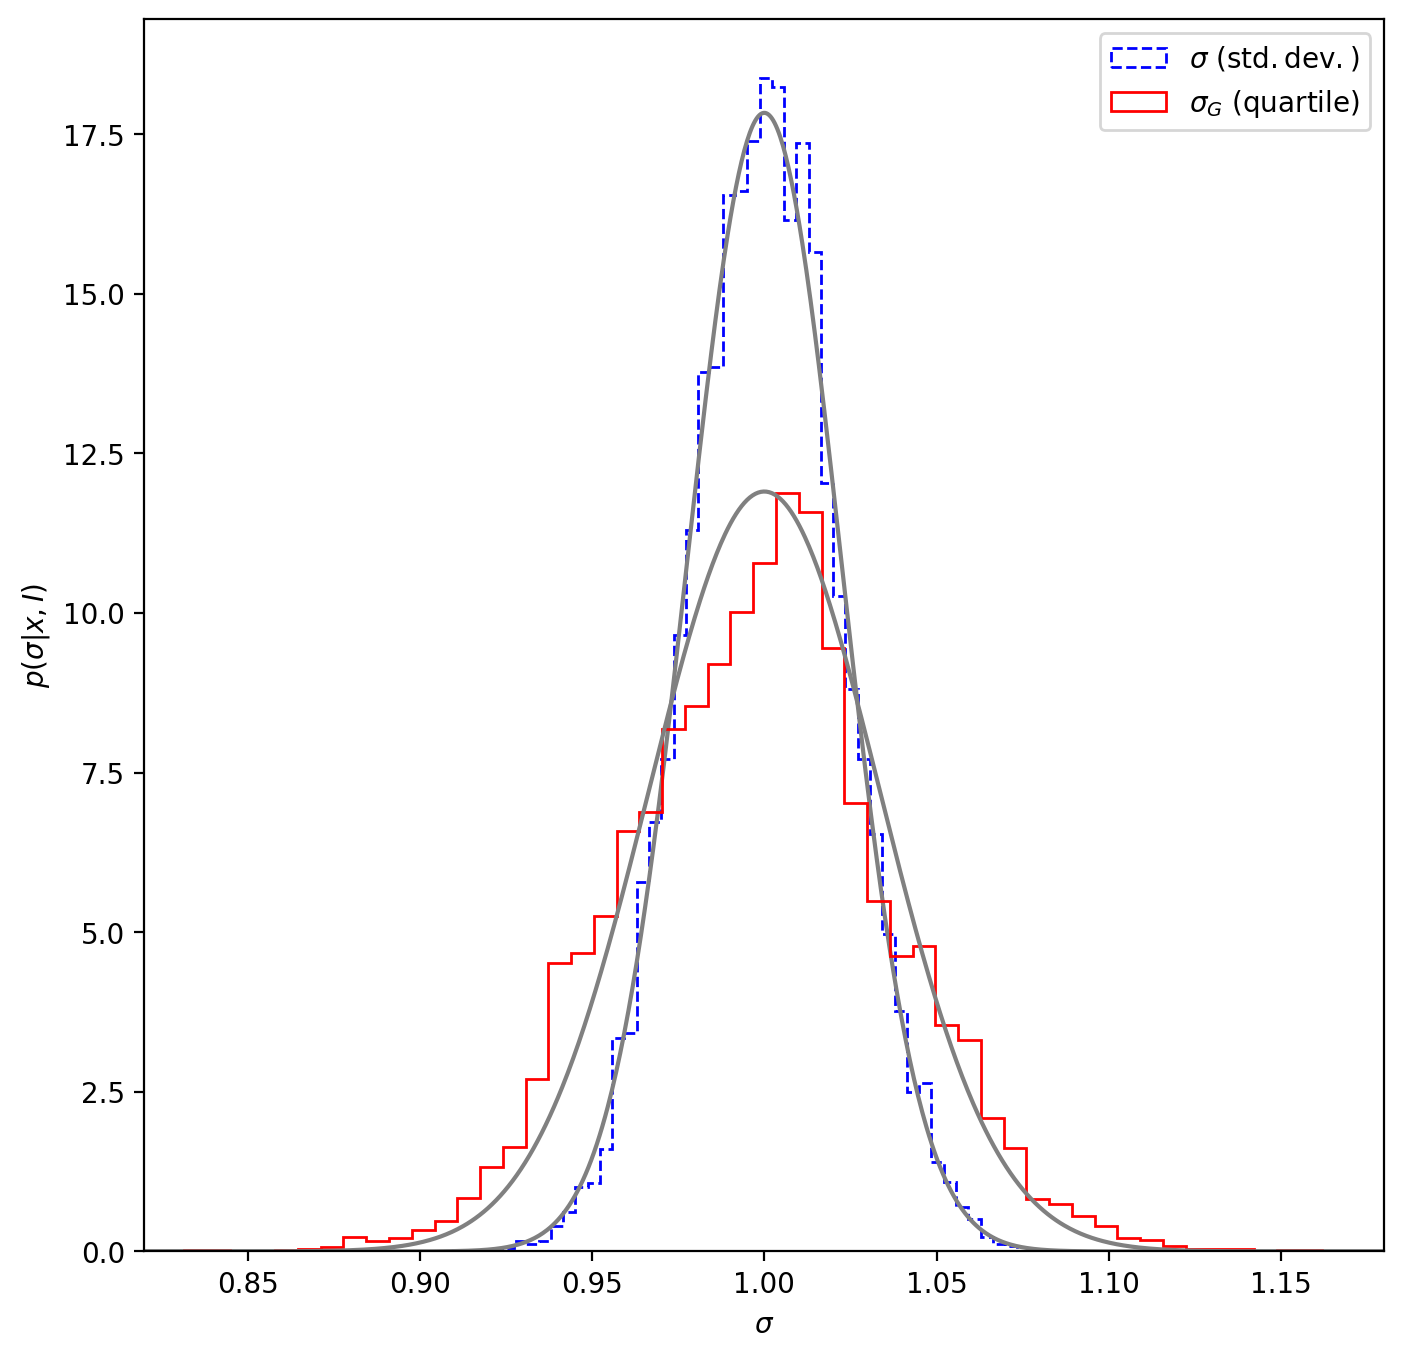

In [2]:
# Ivezic v2, Figure 4.3, modified slightly by GTR and SRT
# %load ../scripts/fig_bootstrap_gaussian.py
# Author: Jake VanderPlas
# License: BSD

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

from astroML.resample import bootstrap
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, 
                          kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, 
                          kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, 
        histtype='step', color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.legend()

plt.show()

The above shows the bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (blue dashed) and $\sigma_G$ (red solid). The thin grey lines show Gaussians with the theoretical widths determined as $\sigma_s = s\, / \sqrt{2(N - 1)}$ and $\sigma_{\sigma_G} = 1.06\, s\, / \sqrt{N}$.

### Jackknife Method 

This is similar to bootsrapping except that we don't use a sample size of $N$. Rather, ***we leave off one or more of the observations*** from $\{x_i\}$. As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

- If we leave out just one datapoint each time, we can make $N$ such datasets that each contain $(N-1)$ data points.
- We compute our statistic or find our model parameters in each of these jackknife datasets.

For jackknifing by leaving out one datapoint, the bias-corrected jackknife estimate of a statistic $\alpha$ is

$$ \alpha^J = \alpha_N + \Delta\alpha,$$

where $\alpha_N$ is the statistic computed on the original dataset, and 

$$ \Delta\alpha = (N-1)\left( \alpha_N - \frac{1}{N}\sum_{i=1}^N \alpha^*_i \right)$$

where $\{\alpha_i^*\}$ are the statistics computed on the $N$ jackknife datasets. 

For asymptoticically normal estimators, the standard error on $\alpha^J$ is

$$ \sigma_\alpha = \sqrt{\frac{1}{N(N-1)}\sum_{i=1}^N [N\alpha_N - \alpha^J - (N-1)\alpha^*_i]^2}.$$

Confidence limits on $\alpha$ can be computed using the Student's $t$ distribution with $t=(\alpha-\alpha^J)/\sigma_\alpha$ and $(N-1)$ degrees of freedom.

**NOTES**
- The jackknife standard error is more reliable than the bias correction.
- Standard jackknife (removing one point) does well for statistics like the mean and standard deviation, but is poor with rank-based statistics (e.g., median, quantiles, $\sigma_G$). 
- This is because (as we've seen) rank-based statistics are not very sensitive to adding/removing single data points. So jackknifing can give many identical values of the statistic!
- This can be resolved by modifying the jackknife to leave off more than one datapoint.

**EXAMPLE**
- We compute jackknife uncertainty estimates for the width of a Gaussian distribution, using the same data as in the bootstrap example.
- The $N$ jackknife estimates of $\sigma$ and $\sigma_G$ will be shown, but the `astroML` jackknife method automatically incorporates the bias correction mentioned above.

<font color='red'>Read through the next cell carefully to understand what's happening when you execute it.</font>

1.0015366861435233 0.02228013942047898
0.597747861971019 0.031353107946452324
mu_1 mean: 1.00 +- 0.02
mu_2 mean: 0.60 +- 0.03


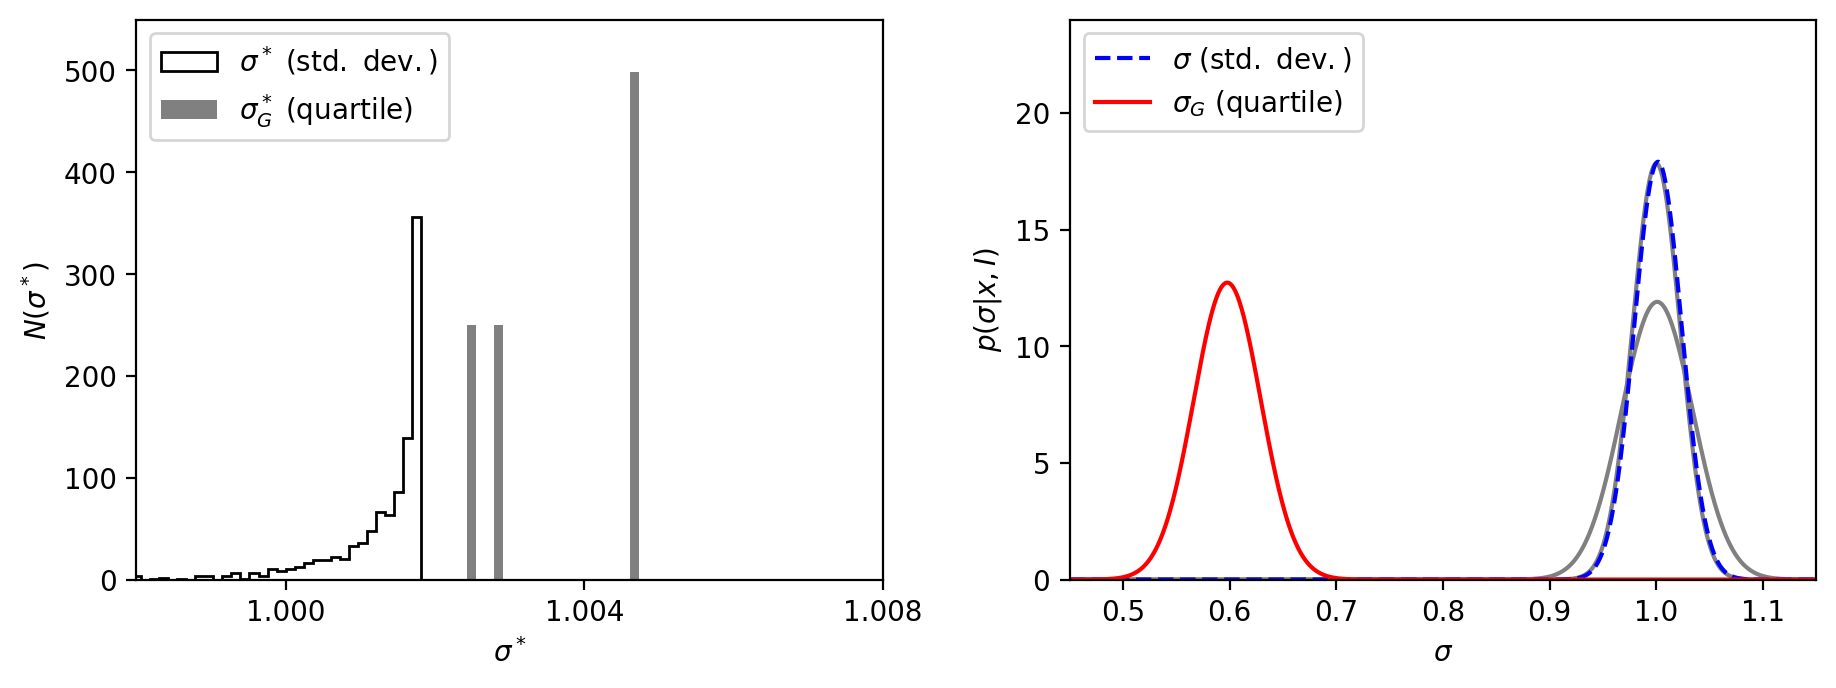

In [3]:
# Ivezic v2, Figure 4.4, modified slightly by SRT
# %load ./scripts/fig_jackknife_gaussian.py
# Author: Jake VanderPlas
# License: BSD

from astroML.resample import jackknife
from astroML.stats import sigmaG

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

# mu1 is the mean of the standard-deviation-based width
mu1, sigma_mu1, mu1_raw = jackknife(data, np.std,
                                    kwargs=dict(axis=1, ddof=1),
                                    return_raw_distribution=True)

pdf1_theory = norm(1, 1. / np.sqrt(2 * (m - 1)))
pdf1_jackknife = norm(mu1, sigma_mu1)
print(mu1, sigma_mu1)

# mu2 is the mean of the interquartile-based width
#  WARNING: do not use the following in practice.  This example
#           shows that jackknife fails for rank-based statistics.
mu2, sigma_mu2, mu2_raw = jackknife(data, sigmaG,
                                    kwargs=dict(axis=1),
                                    return_raw_distribution=True)
pdf2_theory = norm(data.std(), 1.06 / np.sqrt(m))
pdf2_jackknife = norm(mu2, sigma_mu2)
print(mu2, sigma_mu2)

#------------------------------------------------------------
# plot the results
print("mu_1 mean: %.2f +- %.2f" % (mu1, sigma_mu1))
print("mu_2 mean: %.2f +- %.2f" % (mu2, sigma_mu2))

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.11, right=0.95, bottom=0.2, top=0.9,
                    wspace=0.25)

# plot all jacnknife results on histogram
ax = fig.add_subplot(121)
ax.hist(mu1_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma^*\ {\rm (std.\ dev.)}$',
        histtype='stepfilled', fc='white', 
        ec='black', density=False)
ax.hist(mu2_raw, np.linspace(0.996, 1.008, 100),
        label=r'$\sigma_G^*\ {\rm (quartile)}$',
        histtype='stepfilled', fc='gray', 
        density=False)
ax.legend(loc='upper left', handlelength=2)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.004))
ax.set_xlabel(r'$\sigma^*$')
ax.set_ylabel(r'$N(\sigma^*)$')
ax.set_xlim(0.998, 1.008)
ax.set_ylim(0, 550)

# plot the bias-corrected jackknife estimates
ax = fig.add_subplot(122)
x = np.linspace(0.45, 1.15, 1000)
ax.plot(x, pdf1_jackknife.pdf(x),
        color='blue', ls='dashed', 
        label=r'$\sigma\ {\rm (std.\ dev.)}$',
        zorder=2)
ax.plot(x, pdf1_theory.pdf(x), 
        color='gray', zorder=1)
ax.plot(x, pdf2_jackknife.pdf(x),
        color='red', 
        label=r'$\sigma_G\ {\rm (quartile)}$', 
        zorder=2)
ax.plot(x, pdf2_theory.pdf(x), 
        color='gray', zorder=1)
plt.legend(loc='upper left', handlelength=2)


ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')
ax.set_xlim(0.45, 1.15)
ax.set_ylim(0, 24)

plt.show()

The **left panel** shows a histogram over all $N$ jackknife datasets of the widths determined using the sample standard deviation, and using $\sigma_G$ (from the interquartile range). 

The **right panel** shows the bias-corrected jackknife estimates (see above) for the two methods. The gray lines show the theoretical results as before in the bootstrap example. The jackknife result for $\sigma$ matches the theoretical result almost exactly, but note the failure of the jackknife to correctly estimate $\sigma_G$. *Jackknifing does poorly for rank-based statistics!*

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!

## Hypothesis Testing <a class="anchor" id="one"></a>

A common problem in statistics is **hypothesis testing**, i.e., testing whether an observation or observations agree with a certain hypothesis. 

The simplest example is whether a measured value $x_i$ or an entire dataset $\{x_i\}$ are consistent with having been drawn from a Gaussian distribution, $\mathcal{N}(\mu,\sigma)$. In this example, $\mathcal{N}(\mu,\sigma)$ is the ***null hypothesis***, and we are trying to reject it in order to claim that we have measured some effect. 

A great example in astronomy is ***source detection*** in images that suffer from a substantial noise background (e.g., atmospheric fluctuations in optical images).
- Since the background fluctuates, we need the source flux in a given image resolution element (e.g., pixel) to be substantially larger than the background variation in order to give a robust detection.
- Here the null hypothesis is that the flux in each pixel is caused by background fluctuations, and if we can reject it then we can achieve source detection. 
- But note that *rejecting the null hypothesis is not the same as favoring the source hypothesis*! Our understanding of the background could be poor or incomplete, rendering our model of the null hypothesis similarly lacking.

In the image below (from the [photutils](https://photutils.readthedocs.io/en/stable/background.html) package) we have sources embedded in Gaussian image noise. 
- Ideally we would like to be able to find the real sources in here and assign a number that says how much they reject the null background hypothesis. 
- We would establish a threshold in these numbers above which we could accept sources, knowing that we might be falsely rejecting some real ones, but hopefully not accepting too many spurious noise sources.

Imagine we have data $\{x_i\}$. This could be signal strength in time-domain data, or pixel brightness in image data. Under an assumption about the null background distribution, $h_0(x)$, we can compute the probability that a data point would have a value as large or greater than that observed. This is called the ***$p$-value*** of the data:

$$ p_i = \int_{x_i}^\infty h_0(x)dx \equiv 1 - \int_{-\infty}^{x_i} h_0(x)dx = 1-H_0(x_i),$$

where $H_0(x)$ is the CDF (cumulative density function) of the null distribution.

In the image below, we show the distribution of a statistic $S$ under a null hypothesis $\mathcal{H}_\mathrm{null}$. The $p$-value of the observed statistic $S_\mathrm{obs}$ is shown graphically.

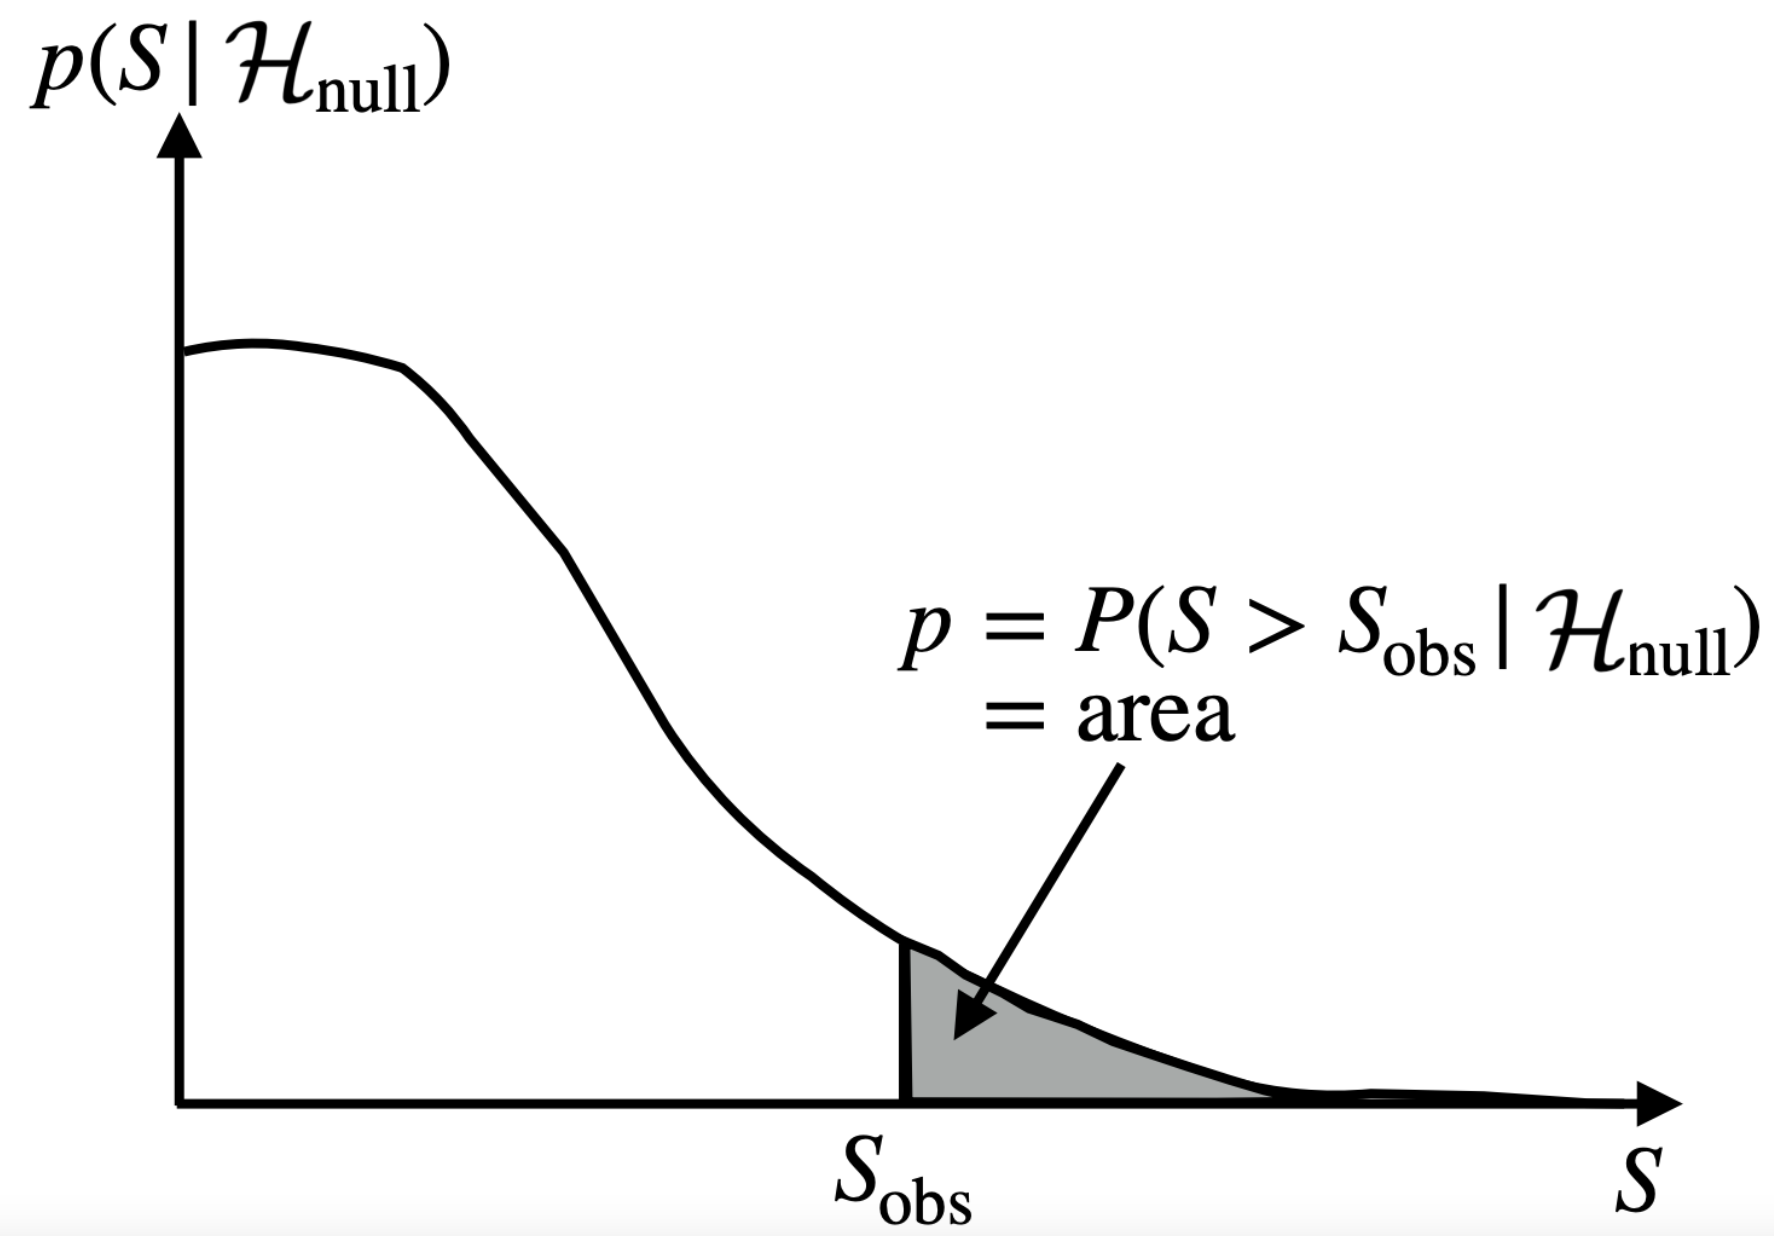

Typically, a threshold $p$-value is adopted, called the **significance, $\alpha$**. In a classification scheme, data would then reject the null hypothesis if $p_i\leq\alpha$. If $\alpha=0.05$, such data would reject the null hypothesis at the $0.05$ significance level. 

**NOTE**
- If we can't reject the null hypothesis then it doesn't mean the data belongs to the background. It could be that our sample is simply not large enough to detect an effect. 
- Rejecting the null hypothesis does not necessarily mean that we've proven a signal hypothesis. Our model of the null hypothesis could be bad, or there could be many other things we have not considered.
- There is ***alot*** of mis-use and abuse of p-values in the scientific literature. Take a quick scan of [this](https://fivethirtyeight.com/features/statisticians-found-one-thing-they-can-agree-on-its-time-to-stop-misusing-p-values/) and [this](https://www.wikiwand.com/en/Misuse_of_p-values) during class, and read thoroughly in your own time. 

**EXAMPLE**

Let's flip a coin 10 times. 
- Defining HEADS as a success event, use `scipy.stats` to define a binomial distribution over $10$ coin flips, where the intrinsic success probability is $0.5$. 
- Plot the probability mass function (the analog of the probability density function for discrete distributions).
- If we get $8$ HEADS, what is the $p$-value with which we reject the hypothesis that the coin is fair?
- <font color='red'>If we get $8$ HEADS, what is the $p$-value with which we reject the hypothesis that the coin is fair?</font>

 <font color='red'>Execute this cell</font>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats

In [ ]:
# Write your code to plot the binomial distribution in here.


In [ ]:
# Write your code to compute the p-value of 8 tails in here.

We look at our coin more shrewdly. In 20 flips, we get a result with $p$-value of $1$ in $10^3$ (i.e., $p = 0.001$). <font color='red'>How many HEADS did we get?</font> *Hint: check the properties of the `scipy.stats.binom` object for useful functions for this.*